# End-to-End Machine Learning Project
## Project: Predicting Ultimate Incurred Claim Cost
---
This notebook provides a comprehensive walkthrough of a machine learning project, from understanding the business problem to preparing the model for deployment. We will use the easy peasy sample dataset from kaggle.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn tools
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Set plotting styles
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
print("Libraries imported successfully.")

Libraries imported successfully.


### 1. Look at the Big Picture
---

#### 1.1 Frame the Problem
*   **Business Objective:** To accurately predict the total final cost (`UltimateIncurredClaimCost`) of a claim when it is first reported. This is crucial for setting financial reserves—the money the Fund must set aside to cover future payments. Better predictions lead to better financial stability and planning.
*   **Machine Learning Frame:** This is a **supervised regression problem**.
    *   **Supervised:** We have historical data with the "correct answer" (the `UltimateIncurredClaimCost`).
    *   **Regression:** We are predicting a continuous numerical value.

#### 1.2 Select a Performance Measure
*   **Root Mean Squared Error (RMSE):** This is the primary metric. It gives us the typical error of our prediction in TZS. A lower RMSE is better. It heavily penalizes large errors, which is important when a few very expensive claims can have a big financial impact.
*   **R-squared (R²):** This metric tells us what proportion of the variance in the ultimate cost our model can explain. A higher R² (closer to 1.0) is better.

#### 1.3 Check the Assumptions
*   **Assumption 1:** The features available at the *initial report* are sufficient to make a reasonable prediction of the *final* cost.
*   **Assumption 2:** The `ClaimDescriptionKeyword` columns (which are likely derived from an NLP model like TF-IDF or an embedding) contain meaningful information about the injury's severity.
*   **Assumption 3:** The relationship between the features and the ultimate cost is learnable by our models.

### 2. Get the Data
---

In [4]:
try:
    df = pd.read_csv('./datasets/easy_peasy.csv')
except FileNotFoundError:
    print("Error: 'easy_peasy.csv' not found. Please ensure the dataset is in the same directory as this notebook.")
    df = pd.DataFrame() # Create an empty dataframe to avoid further errors

if not df.empty:
    print("Dataset loaded. Shape:", df.shape)

Dataset loaded. Shape: (54000, 26)


In [5]:
if not df.empty:
    print("First 5 rows:")
    display(df.head())

    print("\nData Info:")
    df.info()

    print("\nStatistical Summary of Numerical Columns:")
    display(df.describe())

First 5 rows:


,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescriptionKeyword_0,ClaimDescriptionKeyword_1,ClaimDescriptionKeyword_2,ClaimDescriptionKeyword_3,ClaimDescriptionKeyword_4,ClaimDescriptionKeyword_5,ClaimDescriptionKeyword_6,ClaimDescriptionKeyword_7,ClaimDescriptionKeyword_8,ClaimDescriptionKeyword_9,ClaimDescriptionKeyword_10,ClaimDescriptionKeyword_11,InitialIncurredClaimsCost,UltimateIncurredClaimCost
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,2.254325,-1.466085,-1.278155,-0.422165,-0.137039,1.634239,-1.436096,-0.757871,-1.091920,0.880767,0.168497,1.161294,1500,4748.203388
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,2.356002,-1.259903,1.490410,-0.818467,1.788994,0.459482,0.662757,-0.240500,-0.162451,0.665242,0.844019,-1.305332,5500,6326.285819
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,0.817685,-1.088115,1.520340,-0.233031,-0.045712,-0.192742,-0.047881,0.139051,-0.339551,-0.386420,-0.397919,-0.259750,1700,2293.949087
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,4.022864,3.184172,-0.014604,1.219356,0.067053,1.105471,0.609462,1.495272,-0.527257,-0.187209,-0.857031,-0.343594,15000,17786.487170
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,3.383056,0.009941,1.691871,-1.390378,-0.647481,-1.413973,-0.807369,0.243139,1.031237,0.366183,0.427945,-0.038234,2800,4014.002925



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ClaimNumber                 54000 non-null  object 
 1   DateTimeOfAccident          54000 non-null  object 
 2   DateReported                54000 non-null  object 
 3   Age                         54000 non-null  int64  
 4   Gender                      54000 non-null  object 
 5   MaritalStatus               53971 non-null  object 
 6   DependentChildren           54000 non-null  int64  
 7   DependentsOther             54000 non-null  int64  
 8   WeeklyWages                 54000 non-null  float64
 9   PartTimeFullTime            54000 non-null  object 
 10  HoursWorkedPerWeek          54000 non-null  float64
 11  DaysWorkedPerWeek           54000 non-null  int64  
 12  ClaimDescriptionKeyword_0   54000 non-null  float64
 13  ClaimDescriptionKey

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescriptionKeyword_0,ClaimDescriptionKeyword_1,ClaimDescriptionKeyword_2,ClaimDescriptionKeyword_3,ClaimDescriptionKeyword_4,ClaimDescriptionKeyword_5,ClaimDescriptionKeyword_6,ClaimDescriptionKeyword_7,ClaimDescriptionKeyword_8,ClaimDescriptionKeyword_9,ClaimDescriptionKeyword_10,ClaimDescriptionKeyword_11,InitialIncurredClaimsCost,UltimateIncurredClaimCost
count,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,5.400000e+04,5.400000e+04
mean,33.842370,0.119185,0.009944,416.364807,37.735084,4.905759,2.352485,-0.396816,0.011657,-0.048542,-0.007235,0.087407,0.063860,0.005800,-0.022101,-0.008321,0.043518,0.067904,7.841146e+03,1.100337e+04
std,12.122165,0.517780,0.109348,248.638669,12.568704,0.552129,1.095430,1.733289,1.522858,1.121755,1.050046,0.944780,0.929037,0.848007,0.785422,0.719843,0.695790,0.658417,2.058408e+04,3.339099e+04
min,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.022171,-4.608015,-4.336630,-3.105727,-4.250462,-3.678798,-3.360141,-3.262596,-2.545581,-2.834524,-3.246543,-2.444543,1.000000e+00,1.218868e+02
25%,23.000000,0.000000,0.000000,200.000000,38.000000,5.000000,1.575261,-1.647148,-1.199539,-0.801862,-0.620812,-0.551931,-0.523282,-0.586404,-0.527257,-0.477770,-0.412450,-0.335131,7.000000e+02,9.263384e+02
50%,32.000000,0.000000,0.000000,392.200000,38.000000,5.000000,2.202422,-0.909409,-0.021321,-0.160193,-0.073795,0.065841,-0.011992,-0.036147,-0.088811,-0.033242,-0.012551,0.016891,2.000000e+03,3.371242e+03
75%,43.000000,0.000000,0.000000,500.000000,40.000000,5.000000,2.999566,0.567453,1.332303,0.599867,0.559445,0.677067,0.585251,0.537922,0.420868,0.425496,0.463135,0.403220,9.500000e+03,8.197249e+03
max,81.000000,9.000000,5.000000,7497.000000,640.000000,7.000000,6.561085,5.124885,4.924040,5.139204,4.494944,3.788355,4.259305,3.396818,3.639030,3.101630,3.524424,3.438082,2.000000e+06,4.027136e+06


#### 2.1 Create a Test Set
We'll create a standard train/test split. Since this isn't a classification problem with severe imbalance, a simple random split is acceptable.

In [6]:
if not df.empty:
    train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

    print("Training set shape:", train_set.shape)
    print("Test set shape:", test_set.shape)

Training set shape: (43200, 26)
Test set shape: (10800, 26)


### 3. Explore and Visualize the Data
--- 
Using **only the training set** to avoid data snooping.

In [7]:
claims_explore = train_set.copy()

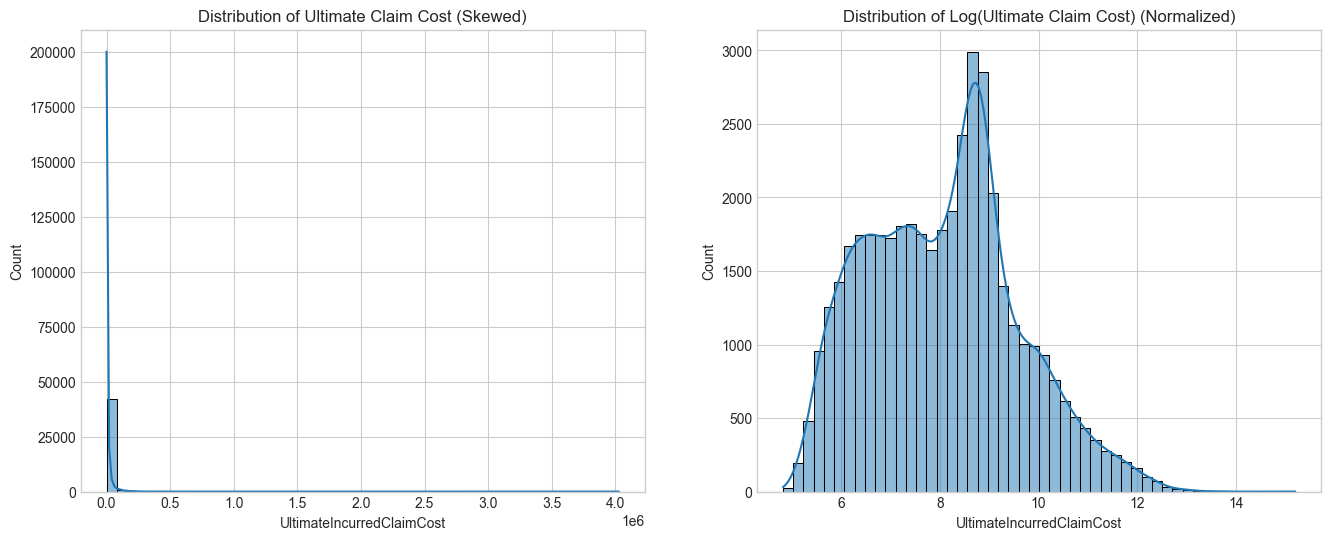

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# The target variable is heavily skewed. This is very common with cost data.
# A log transformation often helps models perform better.
sns.histplot(claims_explore['UltimateIncurredClaimCost'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('Distribution of Ultimate Claim Cost (Skewed)')

sns.histplot(np.log1p(claims_explore['UltimateIncurredClaimCost']), kde=True, ax=axes[1], bins=50)
axes[1].set_title('Distribution of Log(Ultimate Claim Cost) (Normalized)')
plt.show()

**Insight:** The ultimate cost is heavily right-skewed (many small claims, few very large ones). Predicting the **logarithm** of the cost is often easier for models. We will need to remember to transform the predictions back to the original scale for evaluation.

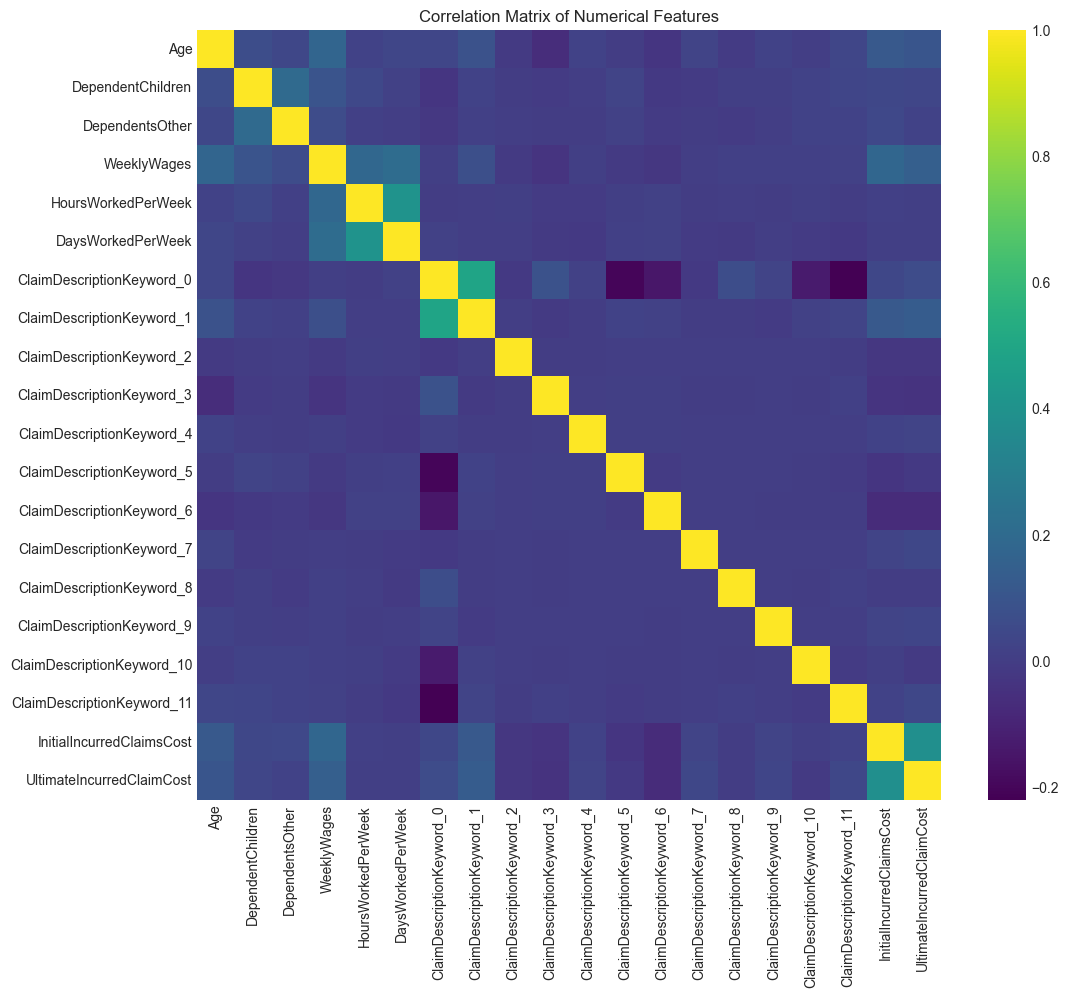


Correlations with UltimateIncurredClaimCost:
UltimateIncurredClaimCost     1.000000
InitialIncurredClaimsCost     0.383227
WeeklyWages                   0.145975
ClaimDescriptionKeyword_1     0.129543
Age                           0.101043
ClaimDescriptionKeyword_0     0.057709
ClaimDescriptionKeyword_11    0.040835
ClaimDescriptionKeyword_7     0.038818
DependentChildren             0.032951
ClaimDescriptionKeyword_9     0.030408
Name: UltimateIncurredClaimCost, dtype: float64


In [9]:
# We select only numerical columns for the correlation matrix
numerical_cols = claims_explore.select_dtypes(include=np.number).columns
corr_matrix = claims_explore[numerical_cols].corr()

# Plot a heatmap of the correlations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='viridis')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Show correlations with the target variable
print("\nCorrelations with UltimateIncurredClaimCost:")
print(corr_matrix['UltimateIncurredClaimCost'].sort_values(ascending=False).head(10))

**Insight:** `InitialIncurredClaimsCost` is, as expected, the strongest predictor. The `ClaimDescriptionKeyword` features show varying levels of correlation, suggesting they contain a useful signal.

### 4. Prepare the Data for Machine Learning
--- 
We will now build a robust preprocessing pipeline. This section is highly technical and critical for production systems.

In [10]:
# Our target is the log-transformed ultimate cost.
y_train = np.log1p(train_set['UltimateIncurredClaimCost'])
X_train = train_set.drop('UltimateIncurredClaimCost', axis=1)

#### 4.1 Custom Transformers for Feature Engineering
Let's create transformers for our date features and any other combinations.

In [11]:
class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['DateTimeOfAccident'] = pd.to_datetime(X_copy['DateTimeOfAccident'])
        X_copy['DateReported'] = pd.to_datetime(X_copy['DateReported'])
        
        # New Feature: Reporting Lag in days
        X_copy['ReportingLag'] = (X_copy['DateReported'] - X_copy['DateTimeOfAccident']).dt.days
        
        # New Feature: Day of the week of accident
        X_copy['AccidentDayOfWeek'] = X_copy['DateTimeOfAccident'].dt.dayofweek
        
        return X_copy.drop(['DateTimeOfAccident', 'DateReported', 'ClaimNumber'], axis=1)

#### 4.2 The Full Transformation Pipeline
We'll combine our custom transformer with standard preprocessing for numerical and categorical features.

In [12]:
# Identify column types *after* our custom transformer has been applied
temp_featurizer = DateFeatureExtractor()
X_train_featured = temp_featurizer.fit_transform(X_train)

# Identify keyword columns, other numerical, and categorical
keyword_features = [f'ClaimDescriptionKeyword_{i}' for i in range(12)]
numerical_features = [col for col in X_train_featured.select_dtypes(include=np.number).columns if col not in keyword_features]
categorical_features = X_train_featured.select_dtypes(exclude=np.number).columns.tolist()

# Define pipelines for each feature type
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# The keyword features are already scaled (likely), so we'll just impute missing values if any
keyword_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])


# Combine into a single preprocessor
full_preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features),
    ("kw", keyword_pipeline, keyword_features)
])

# Create the final, full pipeline
feature_pipeline = Pipeline([
    ('date_extractor', DateFeatureExtractor()),
    ('preprocessor', full_preprocessor)
])

# Fit the pipeline on the training data to prepare it for modeling
X_train_prepared = feature_pipeline.fit_transform(X_train)
print("Data preparation pipeline built and fitted successfully.")

Data preparation pipeline built and fitted successfully.


### 5. Select and Train a Model
---
Let's train a few models and evaluate them using cross-validation.

In [14]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# We'll create full pipelines for each model
lr_pipeline = Pipeline([('prep', feature_pipeline), ('model', LinearRegression())])
rf_pipeline = Pipeline([('prep', feature_pipeline), ('model', RandomForestRegressor(random_state=42))])
gb_pipeline = Pipeline([('prep', feature_pipeline), ('model', GradientBoostingRegressor(random_state=42))])

models = {
    "Linear Regression": lr_pipeline,
    "Random Forest": rf_pipeline,
    "Gradient Boosting": gb_pipeline
}

# Use K-Fold cross-validation to evaluate each model
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    # We use neg_mean_squared_error because CV scorers assume higher is better
    scores = -np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1))
    rmse_scores = np.sqrt(scores)
    results[name] = rmse_scores
    print(f"{name} CV RMSE: {rmse_scores:.4f} (on log-transformed cost)")

# The model with the lowest CV RMSE is our most promising candidate
best_model_name = min(results, key=results.get)
print(f"\nBest performing model from initial selection: {best_model_name}")

Linear Regression CV RMSE: 1.0299 (on log-transformed cost)
Random Forest CV RMSE: 0.6052 (on log-transformed cost)
Gradient Boosting CV RMSE: 0.5996 (on log-transformed cost)

Best performing model from initial selection: Gradient Boosting


### 6. Fine-Tune the Model
--- 
Let's take our best model (likely Gradient Boosting or Random Forest) and fine-tune its hyperparameters.

In [15]:
# Let's assume Gradient Boosting was the best. We'll tune it.
# Note: In a real project, you would programmatically select the best model from the previous step.

gb_full_pipeline = Pipeline([
    ('prep', feature_pipeline),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Define parameter grid
param_grid_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}

# Setup GridSearchCV
grid_search_gb = GridSearchCV(gb_full_pipeline, param_grid_gb, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

print("Best parameters for Gradient Boosting: ", grid_search_gb.best_params_)
best_rmse = np.sqrt(-grid_search_gb.best_score_)
print(f"Best CV RMSE after tuning: {best_rmse:.4f} (on log-transformed cost)")

final_model = grid_search_gb.best_estimator_

Best parameters for Gradient Boosting:  {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Best CV RMSE after tuning: 0.5884 (on log-transformed cost)


#### 6.1 Evaluate the System on the Test Set
Now we use our fine-tuned, final model on the held-out test set.

In [16]:
# Separate test features and labels
X_test = test_set.drop('UltimateIncurredClaimCost', axis=1)
y_test = np.log1p(test_set['UltimateIncurredClaimCost'])

# Make predictions
final_predictions_log = final_model.predict(X_test)

# IMPORTANT: Transform predictions back from log scale to original TZS scale
final_predictions_tzs = np.expm1(final_predictions_log)
y_test_tzs = np.expm1(y_test)

# Calculate final metrics on the original scale
final_rmse = np.sqrt(mean_squared_error(y_test_tzs, final_predictions_tzs))
final_r2 = r2_score(y_test_tzs, final_predictions_tzs)

print(f"--- Final Model Evaluation on Test Set (in TZS) ---")
print(f"Final Test RMSE: {final_rmse:,.2f} TZS")
print(f"Final Test R-squared: {final_r2:.4f}")

--- Final Model Evaluation on Test Set (in TZS) ---
Final Test RMSE: 25,681.77 TZS
Final Test R-squared: 0.2735


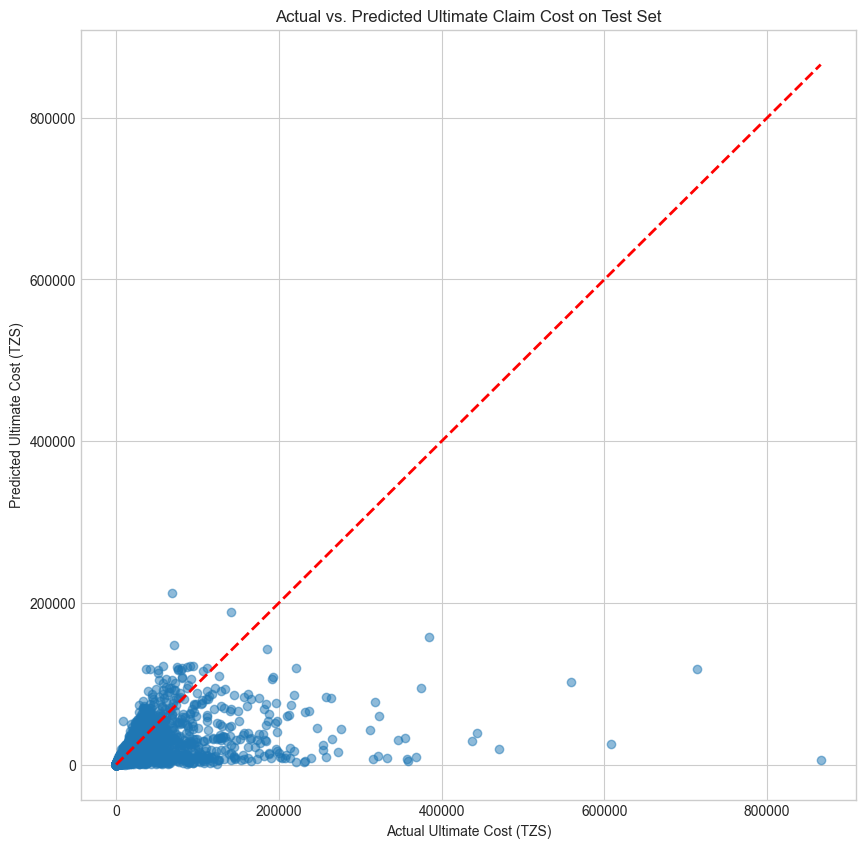

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test_tzs, final_predictions_tzs, alpha=0.5)
plt.plot([y_test_tzs.min(), y_test_tzs.max()], [y_test_tzs.min(), y_test_tzs.max()], '--r', linewidth=2)
plt.xlabel("Actual Ultimate Cost (TZS)")
plt.ylabel("Predicted Ultimate Cost (TZS)")
plt.title("Actual vs. Predicted Ultimate Claim Cost on Test Set")
plt.show()

### 7. Launch, Monitor, and Maintain the System
---

In [ ]:
# Cell 15: Launch - Save the Final Pipeline
import joblib
joblib.dump(final_model, 'ultimate_cost_predictor_pipeline.pkl')
print("Final model pipeline saved to 'ultimate_cost_predictor_pipeline.pkl'")

#### 7.1 Monitoring and Maintenance Plan
*   **Launch:** Deploy the saved pipeline as an API. The claims system calls this API with new claim data (e.g., Age, Wages, Keywords) to get a predicted `UltimateIncurredClaimCost`. This predicted value is then used to set the initial financial reserve for that claim.
*   **Monitor:**
    *   **Performance:** Periodically (e.g., monthly), compare the model's initial predictions for claims that have recently closed against their actual final costs. Track the RMSE over time to detect performance degradation.
    *   **Concept Drift:** Monitor the statistical distribution of key input features. If the average `WeeklyWages` of claimants significantly increases due to economic changes, the model may become less accurate.
*   **Maintain:**
    *   **Retraining:** Automate a retraining script to run (e.g., every quarter) on newly closed and finalized claims data. This ensures the model adapts to changes in the workplace and economic environment.
    *   **Versioning:** Store each retrained model as a new version. Before deploying a new version, evaluate it against the old one on a hold-out validation set to ensure it's an actual improvement.